# 뉴스 카테고리 다중분류

이번 프로젝트에서는 이전 LMS에서 진행하였던 뉴스 카테고리 다중분류문제를 여러가지 데이터셋에 대하여 적용해보고 모델이나 데이터셋에 따른 성능분석을 진행해보겠다.

Dataset 
---
- [로이터 뉴스](https://keras.io/api/datasets/reuters/)
 - 46가지 토픽으로 라벨이 달린 11,228개의 로이터 뉴스로 이루어진 데이터셋
 - 각 뉴스는 단어 인덱스의 시퀀스로 인코딩되어 있다.

- 토픽 : 46개 (뉴스 카테고리)
 - 참고 : https://github.com/SteffenBauer/KerasTools/tree/master/Reuters_Analysis
 - category : https://liaison.reuters.com/tools/topic-codes
```
'cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'
```



In [74]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

## EDA

In [75]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [76]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


### 결측치 및 중복 데이터 확인

In [77]:
X_train = pd.Series(x_train)
X_test = pd.Series(x_test)

In [78]:
X_train.isnull().sum(), X_test.isnull().sum()

(0, 0)

In [79]:
X_train.duplicated().sum(), X_test.duplicated().sum()

(529, 32)

로이터 뉴스 데이터셋에는 결측치는 없고 중복 데이터가 훈련셋에서 529건, 테스트셋에서 32건이 존재한다. 중복데이터만 따로 확인해보자.

In [80]:
X_train_dup = X_train[X_train.duplicated()]

In [81]:
X_train_dup.head()

841     [1, 53, 187, 15508, 14, 61, 16037, 341, 59, 24...
855     [1, 53, 258, 26, 14, 134, 26, 39, 2228, 18, 14...
893     [1, 4, 60, 5, 130, 40, 414, 1087, 95, 97, 68, ...
987     [1, 53, 74, 155, 26, 14, 46, 196, 26, 39, 74, ...
1090    [1, 53, 74, 142, 26, 14, 46, 279, 26, 39, 74, ...
dtype: object

In [82]:
print(X_train_dup[987])

[1, 53, 74, 155, 26, 14, 46, 196, 26, 39, 74, 2558, 18, 14, 46, 3232, 18, 86, 44, 8261, 18, 14, 44, 5020, 18, 17, 12]


In [83]:
for i, v in enumerate(x_train):
    if v == [1, 53, 74, 155, 26, 14, 46, 196, 26, 39, 74, 2558, 18, 14, 46, 3232, 18, 86, 44, 8261, 18, 14, 44, 5020, 18, 17, 12]:
        print("index : {}, value: {}".format(i,v))

index : 204, value: [1, 53, 74, 155, 26, 14, 46, 196, 26, 39, 74, 2558, 18, 14, 46, 3232, 18, 86, 44, 8261, 18, 14, 44, 5020, 18, 17, 12]
index : 987, value: [1, 53, 74, 155, 26, 14, 46, 196, 26, 39, 74, 2558, 18, 14, 46, 3232, 18, 86, 44, 8261, 18, 14, 44, 5020, 18, 17, 12]


위의 사례처럼 204번째 뉴스와 987번의 뉴스는 동일한 내용으로 보고 첫번째 뉴스를 제외하고 중복된 뒤의 뉴스의 내용은 삭제하겠다.

In [84]:
X_train.drop_duplicates(keep='first', inplace=True)
X_test.drop_duplicates(keep='first', inplace=True)

In [85]:
X_train.duplicated().sum(), X_test.duplicated().sum()

(0, 0)

In [86]:
x_train = X_train.to_numpy()
x_test = X_test.to_numpy()

In [87]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8453
테스트 샘플의 수: 2214


기존 데이터셋에서 중복 데이터를 제외하여 훈련 샘플의 수: 8982-> 8453건, 테스트 샘플의 수: 2246->2214건이 남았다.

### 뉴스 길이 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 최소 길이 :13
훈련용 뉴스의 평균 길이 :144.87448243227257


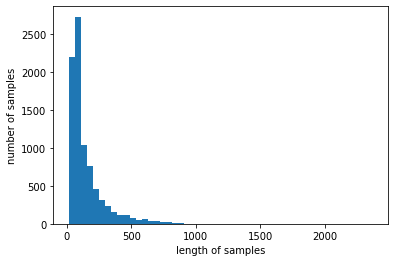

In [88]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 최소 길이 :{}'.format(min(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

훈련용 뉴스 문서에 길이는 13에서 2376까지의 분포로 평균길이는 약145이다. 막대그래프로 보았을때 문서의 길이가 500이상이 되었을때 샘플 분포가 적은것을 알수 있다. 

만약 RNN모델로 텍스트 분류를 진행한다면 훈련에 적절한 최대 문장의 길이를(위의 경우 500) 설정하고 길이보다 짧은 문서는 pad를 추가하여 수치화하는 과정을 가질것이다. 

하지만 본 프로젝트에서는 머신러닝과 TF-IDF를 활용하여 텍스트 분류를 진행할 것이므로 EDA는 여기까지 마치도록하자. 



### 단어사전 설정
- reuters_word_index.json 파일을 제공
 - 단어와 정수 인덱스를 매핑한 딕셔너리

In [89]:
word_to_index = reuters.get_word_index(path="reuters_word_index.json")
print(word_to_index)

{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, }


여기서 텍스트 시퀀스로 바꾸기위해 index_to_word사전을 역으로 구성해보자. 단 index 0,1,2에 대응하는 세가지 토큰도 word_to_index에 추가해주어야한다.

In [90]:
index_to_word = { index+3 : word for word, index in word_to_index.items() }

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

전처리시 중복값이 있었던 뉴스(204번째 뉴스)의 내용을 한번확인해보자. 

In [91]:
news_category = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

def get_category(label):
    return news_category[label]

print(x_train[204])
print(' '.join([index_to_word[index] for index in x_train[204]]))
print('News category:', get_category(y_train[204]))

[1, 53, 74, 155, 26, 14, 46, 196, 26, 39, 74, 2558, 18, 14, 46, 3232, 18, 86, 44, 8261, 18, 14, 44, 5020, 18, 17, 12]
<sos> shr profit six cts vs loss 18 cts net profit 156 000 vs loss 212 000 revs 5 094 000 vs 5 669 000 reuter 3
News category: coffee


204번째 뉴스는 coffee카테고리에 속한다. 뉴스에서 증시나 금융정보가 중요한 만큼 숫자 데이터가 텍스트 데이터와 함께 토큰화된 점이 눈에 뛴다. 토큰화시 숫자는 3자리로 나누어 처리한것같다. 

다른 카테고리에 속하는 뉴스도 확인해보자.

In [45]:
print(' '.join([index_to_word[index] for index in x_train[200]]))
print('News category:', get_category(y_train[200]))

<sos> japan's seasonally adjusted unemployment rate rose to a record 3 0 pct in january the worst since the government started compiling unemployment statistics under its current system in 1953 up from the previous record 2 9 pct in december the government's management and coordination agency said unemployment was up from 2 8 pct a year earlier unadjusted january unemployment totalled 1 82 mln people up from 1 61 mln in december and 1 65 mln a year earlier male unemployment in january remained at 2 9 pct equal to the second worst level set last december record male unemployement of 3 1 pct was set in july 1986 female unemployment in january remained at 3 0 pct equal to the record level marked in april august september and december last year january's record 3 0 pct unemployment rate mainly stemmed from loss of jobs in manufacturing industries particularly in export related firms due to the yen's continuing appreciation against the dollar officials said employment in manufacturing indus

일본의 실업상황 관련된 뉴스 같은데 jobs 카테고리에 속한다고 나와있다.

위 데이터를 구성하는 방법으로 데이터셋을 로드하는 함수를 정의하고 실험을 진행해보겠다.

## 라이브러리

In [ ]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras

## Data load 함수 정의
1. 최빈도 단어들중 num_words만큼 데이터셋을 구성
2. 정수형 데이터를 텍스트 데이터로 변환
3. 사이킷런의 CountVectorizer()을 사용하여 Document Term Matrix(DTM) 구성
4. 사이킷런의 TfidfTransformer() 을 사용하여 DTM을 TF-IDF Matrix로 변환한후 리턴

In [92]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def load_news_data(num_words):
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

   #중복 제거
    X_train = pd.Series(x_train)
    X_test = pd.Series(x_test)
    X_train.drop_duplicates(keep='first', inplace=True)
    X_test.drop_duplicates(keep='first', inplace=True)

    df_train = pd.DataFrame(x_train, columns=['text'])
    df_test = pd.DataFrame(x_test, columns=['text'])

    #리스트 타입은 mutable 하여 중복 체크가 되지않아 str타입으로 변경한 컬럼을 따로 추가한다.
    df_train['str_text'] = df_train.text.astype(str)
    df_test['str_text'] = df_test.text.astype(str)
    df_train['category'] = y_train
    df_test['category'] = y_test

    #중복 제거
    df_train.drop_duplicates(['str_text'], keep='first', inplace=True)
    df_test.drop_duplicates(['str_text'], keep='first', inplace=True)

    #다시 넘파일 배열로 변경시켜준다.
    x_train = df_train.text.to_numpy()
    y_train = df_train.category.to_numpy()
    x_test = df_test.text.to_numpy()
    y_test = df_test.category.to_numpy()

    decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded.append(t)
    x_train = decoded

    decoded = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded.append(t)
    x_test = decoded

    print('load data :',  len(x_train), len(x_test)) 

    dtmvector = CountVectorizer()
    tfidf_transformer = TfidfTransformer()

    x_train_dtm = dtmvector.fit_transform(x_train)    #훈련 데이터를 DTM으로 변환
    tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm) #DTM을 TF-IDF 행렬로 변환

    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
    
    print('transformer data :', tfidfv_train.shape, tfidfv_test.shape) 

    return tfidfv_train, y_train, tfidfv_test, y_test

## f1- score 함수

- keras에서 f1-score와 관련 API를 지원하지않으므로  따로 f1-score를 구하는 함수를 정의해주고 딥러닝 모델 훈련시 Metric에 추가하여 참조하도록했다.

In [94]:
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())

    # return a single tensor value
    return _f1score


In [108]:
#성능 지표 저장을 위한 데이터프레임 변수
columns = ["Acc", "F1"]
index = ["Naive Bayes", "ComplementNB", "LogisticRegression", "Support Vector Machine",\
         "Decision Tree", "Random Forest", "GradientBoosting", "Voting", 'DNN']

In [96]:
model_nb = MultinomialNB()
model_cb = ComplementNB()
model_lr = LogisticRegression(C=10000, penalty='l2')
model_svc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
model_dt = DecisionTreeClassifier(max_depth=10, random_state=0)
model_rf = RandomForestClassifier(n_estimators=5, random_state=0)
model_gb = GradientBoostingClassifier(random_state=0)

model_dict = {}
model_dict[index[0]] = model_nb
model_dict[index[1]] = model_cb
model_dict[index[2]] = model_lr
model_dict[index[3]] = model_svc
model_dict[index[4]] = model_dt
model_dict[index[5]] = model_rf
model_dict[index[6]] = model_gb

머신러닝 알고리즘중 위 7개 모델에 대하여 훈련, 테스트를 진행하는 함수를 정의 하겠다. 모델 훈련, 테스트 결과를 저장할 dataframe정보도 함께 넘겨주어야한다.

보팅모델은 7개 모델의 결과에서 성능이 좋은 3개의 모델을 사용하여 따로 구성하겠다. 

In [97]:
# 7개 ML 모델 훈련및 테스트 함수
def excute_train_test(x_train, y_train, x_test, y_test, df_scroe):    
    for model_name, model in model_dict.items():
        model.fit(x_train, y_train) #훈련
        y_pred = model.predict(x_test) #예측
        acc = accuracy_score(y_test, y_pred) #정확도 평가
        f1 = f1_score(y_test, y_pred, average='weighted') #f1-score 평가
        df_scroe.loc[df_scroe.index == model_name] = (acc, f1) #평가 점수 설정
        print(model_name, ':', acc, f1)

In [129]:
# Voting 훈련및 테스트 함수
def excute_voting_train_test(x_train, y_train, x_test, y_test, df_scroe, estimators):
    model_vt = VotingClassifier(estimators=estimators,
                voting='soft', n_jobs=-1)
    model_vt.fit(x_train, y_train)#훈련
    y_pred = model_vt.predict(x_test) #예측
    acc = accuracy_score(y_test, y_pred) #정확도 평가
    f1 = f1_score(y_test, y_pred, average='weighted') #f1-score 평가
    df_scroe.loc[df_scroe.index == 'Voting'] = (acc, f1)#평가 점수 설정
    print('Voting', ':', acc, f1)

csr_matrix(압축 희소 행렬)을 딥러닝 모델에 학습시키면 에러가 발생하므로 넘파이 행렬로 변경해주는 과정이 필요하다.

- scipy.sparse.csr_matrix.todense() 메소드


In [123]:
# 딥러닝 모델 훈련및 테스트 함수

from tensorflow.keras.callbacks import EarlyStopping

def excute_dnn_train_test(x_train, y_train, x_test, y_test, df_scroe): 
    # sparse matrix -> dense array로 변경
    x_train_ds = x_train.todense()
    x_test_ds = x_test.todense()

    CLASSES = 46
    input_dim = x_train_ds.shape[1] 

    model_nn = keras.Sequential()
    model_nn.add(keras.layers.Dense(256, input_dim=input_dim, activation='relu'))
    model_nn.add(keras.layers.Dense(128, activation='relu'))
    model_nn.add(keras.layers.Dense(46, activation='softmax'))

    METRICS = ['accuracy', f1score]
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, min_delta=0.05) #val_loss 관찰 # 3epoch 동안 손실이 0.05이상 개선되지 않을 경우 훈련 중지

    model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=METRICS)
    model_nn.fit(x_train_ds, y_train_10000, validation_split=0.2, epochs=5, callbacks=[early_stopping])

    _loss, _acc, _f1score = model_nn.evaluate(x_test_ds, y_test, verbose=2)
    df_scroe.loc[df_scroe.index == 'DNN'] = (_acc, _f1score)

## 실험 방법

**데이터셋**

1. 빈도수 상위 10000개 : 이전 LMS에서 진행했던 데이터셋
2. 모든 단어 - None
3. 빈도수 상위 7500개
3. 빈도수 상위 5000개
4. 빈도수 상위 2500개

**사용할 모델**
- ML 모델
 - 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅
- 딥러닝 모델 


## (1) 데이터셋 - Vocabulary size = 10000

이전 LMS에서 진행했던 10000개의 단어로 구성된 뉴스 데이터셋으로 훈련, 테스트를 진행해보겠다. LMS와 다른점은 중복을 제거했다는 점이다.

In [104]:
df_score_10000 = pd.DataFrame(None, index=index, columns=columns) # 모델별 성능 지표 저장 

x_train_10000, y_train_10000, x_test_10000, y_test_10000 = load_news_data(10000)
excute_train_test(x_train_10000, y_train_10000, x_test_10000, y_test_10000, df_score_10000)   

Naive Bayes : 0.6558265582655827 0.5732800811798514
ComplementNB : 0.7750677506775068 0.7494529368479081


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression : 0.8139114724480578 0.809521241932279


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machine : 0.7795844625112918 0.7755128612921335
Decision Tree : 0.6201445347786811 0.5766074276420602
Random Forest : 0.6802168021680217 0.6528981463659351
GradientBoosting : 0.7728093947606143 0.7696990010475626


LMS에서 성능과 비교했을때 정확도 지표들이 NB, CNB는 비슷했고, 나머지모델들에 대해서는 1%가량 높게 나왔다. 중복을 제거한 데이터셋이 어느정도 성능에 기여하는 면이 있다고 보고 이대로 실험을 진행해도 좋겠다.

Voting 모델에 대한 훈련과 테스트도 함께 진행해보자.
- 보팅모델은 위 결과에서 성능이 좋은 3개의 모델을 사용하여 구성하겠다.  
 - LogisticRegression, ComplementNB, LinearSVC(제외), GradientBoostingClassifier
- 성능면에서 LinearSVC 모델이 좋게 나왔지만 LinearSVC는 각카테고리별 예측확률을 제공하지않아 soft 보팅에 사용할수없어 제외하였다.

In [106]:
estimators=[('lr', LogisticRegression(C=10000, penalty='l2')),
             ('cb', ComplementNB()), ('gbc', GradientBoostingClassifier(random_state=0)) ]

excute_voting_train_test(x_train_10000, y_train_10000, x_test_10000, y_test_10000, df_score_10000, estimators)

Voting : 0.8229448961156278 0.8196364293036051


In [124]:
excute_dnn_train_test(x_train_10000, y_train_10000, x_test_10000, y_test_10000, df_score_10000)   

Epoch 1/5
212/212 [==============================] - 4s 14ms/step - loss: 1.6531 - accuracy: 0.6189 - f1score: 0.6391 - val_loss: 0.9669 - val_accuracy: 0.7658 - val_f1score: 0.8639
Epoch 2/5
212/212 [==============================] - 3s 15ms/step - loss: 0.6984 - accuracy: 0.8373 - f1score: 0.8956 - val_loss: 0.7233 - val_accuracy: 0.8285 - val_f1score: 0.8963
Epoch 3/5
212/212 [==============================] - 4s 17ms/step - loss: 0.3077 - accuracy: 0.9342 - f1score: 0.9488 - val_loss: 0.6517 - val_accuracy: 0.8504 - val_f1score: 0.9325
Epoch 4/5
212/212 [==============================] - 3s 16ms/step - loss: 0.1149 - accuracy: 0.9787 - f1score: 0.9823 - val_loss: 0.6498 - val_accuracy: 0.8457 - val_f1score: 0.9481
70/70 - 0s - loss: 0.9749 - accuracy: 0.8008 - f1score: 0.9465 - 344ms/epoch - 5ms/step


## (2) 데이터셋 - Vocabulary size = None

In [126]:
df_score_all = pd.DataFrame(None, index=index, columns=columns) # 모델별 성능 지표 저장 

x_train_all, y_train_all, x_test_all, y_test_all = load_news_data(None)
excute_train_test(x_train_all, y_train_all, x_test_all, y_test_all, df_score_all)   

load data : 8453 2214
transformer data : (8453, 26506) (2214, 26506)
Naive Bayes : 0.5984643179765131 0.5029231085851672
ComplementNB : 0.7646793134598012 0.7326788250046982


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression : 0.8134598012646793 0.8088907179060477


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machine : 0.7881662149954833 0.7846498291949523
Decision Tree : 0.6345980126467932 0.6111470758748561
Random Forest : 0.6508581752484192 0.6229052972298259
GradientBoosting : 0.7719060523938572 0.7687850153955653


In [130]:
estimators=[('lr', LogisticRegression(C=10000, penalty='l2')),
             ('cb', ComplementNB()), ('gbc', GradientBoostingClassifier(random_state=0)) ]

excute_voting_train_test(x_train_all, y_train_all, x_test_all, y_test_all, df_score_all, estimators)

Voting : 0.8229448961156278 0.8186520936114796


In [131]:
excute_dnn_train_test(x_train_all, y_train_all, x_test_all, y_test_all, df_score_all)

Epoch 1/5
212/212 [==============================] - 7s 29ms/step - loss: 1.6415 - accuracy: 0.6224 - f1score: 0.6328 - val_loss: 0.9764 - val_accuracy: 0.7670 - val_f1score: 0.8502
Epoch 2/5
212/212 [==============================] - 6s 27ms/step - loss: 0.6596 - accuracy: 0.8477 - f1score: 0.8953 - val_loss: 0.7383 - val_accuracy: 0.8220 - val_f1score: 0.9137
Epoch 3/5
212/212 [==============================] - 6s 27ms/step - loss: 0.2475 - accuracy: 0.9510 - f1score: 0.9588 - val_loss: 0.6379 - val_accuracy: 0.8522 - val_f1score: 0.9273
Epoch 4/5
212/212 [==============================] - 6s 27ms/step - loss: 0.0789 - accuracy: 0.9874 - f1score: 0.9870 - val_loss: 0.6287 - val_accuracy: 0.8551 - val_f1score: 0.9476
70/70 - 1s - loss: 0.9563 - accuracy: 0.8071 - f1score: 0.9465 - 592ms/epoch - 8ms/step


## (3) 데이터셋 - Vocabulary size = 7500

In [138]:
df_score_7500 = pd.DataFrame(None, index=index, columns=columns) # 모델별 성능 지표 저장 

x_train_7500, y_train_7500, x_test_7500, y_test_7500 = load_news_data(7500)
excute_train_test(x_train_7500, y_train_7500, x_test_7500, y_test_7500, df_score_7500)   

load data : 8452 2214
transformer data : (8452, 7296) (2214, 7296)
Naive Bayes : 0.6653116531165312 0.585773421461886
ComplementNB : 0.7728093947606143 0.7480028713138225


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression : 0.8130081300813008 0.8089560090272443


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machine : 0.7886178861788617 0.7838669438153377
Decision Tree : 0.6264679313459801 0.5825582919322535
Random Forest : 0.6775067750677507 0.6491907628107406
GradientBoosting : 0.7673893405600722 0.7642015862163347


In [139]:
estimators=[('lr', LogisticRegression(C=10000, penalty='l2')),
             ('cb', ComplementNB()), ('gbc', GradientBoostingClassifier(random_state=0)) ]

excute_voting_train_test(x_train_7500, y_train_7500, x_test_7500, y_test_7500, df_score_7500, estimators)

Voting : 0.8215898825654924 0.8188925479141458


In [140]:
excute_dnn_train_test(x_train_7500, y_train_7500, x_test_7500, y_test_7500, df_score_7500)

Epoch 1/5
212/212 [==============================] - 3s 12ms/step - loss: 2.2484 - accuracy: 0.4446 - f1score: 0.4917 - val_loss: 2.7649 - val_accuracy: 0.2768 - val_f1score: 0.6674
Epoch 2/5
212/212 [==============================] - 2s 11ms/step - loss: 1.6380 - accuracy: 0.5822 - f1score: 0.7464 - val_loss: 2.9823 - val_accuracy: 0.2413 - val_f1score: 0.7471
Epoch 3/5
212/212 [==============================] - 2s 11ms/step - loss: 1.1373 - accuracy: 0.7029 - f1score: 0.8290 - val_loss: 3.4467 - val_accuracy: 0.2318 - val_f1score: 0.8080
70/70 - 0s - loss: 1.3206 - accuracy: 0.6631 - f1score: 0.8138 - 267ms/epoch - 4ms/step


## (4) 데이터셋 - Vocabulary size = 5000

In [132]:
df_score_5000 = pd.DataFrame(None, index=index, columns=columns) # 모델별 성능 지표 저장 

x_train_5000, y_train_5000, x_test_5000, y_test_5000 = load_news_data(5000)
excute_train_test(x_train_5000, y_train_5000, x_test_5000, y_test_5000, df_score_5000)   

load data : 8452 2214
transformer data : (8452, 4867) (2214, 4867)
Naive Bayes : 0.6725383920505872 0.5980940294490975
ComplementNB : 0.7732610659439928 0.7476311622462234


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression : 0.8071364046973803 0.8025318360667885


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machine : 0.7773261065943993 0.774132259282198
Decision Tree : 0.6300813008130082 0.5834011675677825
Random Forest : 0.6838301716350497 0.6564862518826285
GradientBoosting : 0.7705510388437218 0.768656012511734


In [133]:
estimators=[('lr', LogisticRegression(C=10000, penalty='l2')),
             ('cb', ComplementNB()), ('gbc', GradientBoostingClassifier(random_state=0)) ]

excute_voting_train_test(x_train_5000, y_train_5000, x_test_5000, y_test_5000, df_score_5000, estimators)

Voting : 0.8197831978319783 0.8171697839357912


In [134]:
excute_dnn_train_test(x_train_5000, y_train_5000, x_test_5000, y_test_5000, df_score_5000)

Epoch 1/5
212/212 [==============================] - 3s 10ms/step - loss: 2.2464 - accuracy: 0.4382 - f1score: 0.4906 - val_loss: 2.7472 - val_accuracy: 0.2839 - val_f1score: 0.6287
Epoch 2/5
212/212 [==============================] - 2s 8ms/step - loss: 1.7079 - accuracy: 0.5686 - f1score: 0.7250 - val_loss: 2.8947 - val_accuracy: 0.2578 - val_f1score: 0.7264
Epoch 3/5
212/212 [==============================] - 2s 8ms/step - loss: 1.3113 - accuracy: 0.6582 - f1score: 0.8044 - val_loss: 3.2949 - val_accuracy: 0.2472 - val_f1score: 0.7956
70/70 - 0s - loss: 1.2708 - accuracy: 0.6721 - f1score: 0.8086 - 216ms/epoch - 3ms/step


## (5) 데이터셋 - Vocabulary size = 2500

In [135]:
df_score_2500 = pd.DataFrame(None, index=index, columns=columns) # 모델별 성능 지표 저장 

x_train_2500, y_train_2500, x_test_2500, y_test_2500 = load_news_data(2500)
excute_train_test(x_train_2500, y_train_2500, x_test_2500, y_test_2500, df_score_2500)   

load data : 8452 2214
transformer data : (8452, 2430) (2214, 2430)
Naive Bayes : 0.6878952122854561 0.6284657660656189
ComplementNB : 0.7610659439927733 0.7327923173721271


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression : 0.7953929539295393 0.7900761552317107


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machine : 0.7570009033423668 0.7539242118341188
Decision Tree : 0.6242095754290876 0.5843968375655397
Random Forest : 0.7073170731707317 0.6835215646043322
GradientBoosting : 0.7669376693766937 0.7626622073073209


In [136]:
estimators=[('lr', LogisticRegression(C=10000, penalty='l2')),
             ('cb', ComplementNB()), ('gbc', GradientBoostingClassifier(random_state=0)) ]

excute_voting_train_test(x_train_2500, y_train_2500, x_test_2500, y_test_2500, df_score_2500, estimators)

Voting : 0.8102981029810298 0.8062522467501312


In [137]:
excute_dnn_train_test(x_train_2500, y_train_2500, x_test_2500, y_test_2500, df_score_2500)

Epoch 1/5
212/212 [==============================] - 2s 7ms/step - loss: 2.2510 - accuracy: 0.4461 - f1score: 0.5000 - val_loss: 2.7246 - val_accuracy: 0.2431 - val_f1score: 0.6385
Epoch 2/5
212/212 [==============================] - 1s 6ms/step - loss: 1.7729 - accuracy: 0.5529 - f1score: 0.7211 - val_loss: 2.8802 - val_accuracy: 0.2484 - val_f1score: 0.7057
Epoch 3/5
212/212 [==============================] - 1s 5ms/step - loss: 1.4936 - accuracy: 0.6156 - f1score: 0.7817 - val_loss: 3.0188 - val_accuracy: 0.2354 - val_f1score: 0.7413
70/70 - 0s - loss: 1.2581 - accuracy: 0.7082 - f1score: 0.7300 - 158ms/epoch - 2ms/step


# 실험 결과

데이터셋에 따른 모델별 평가 점수를 알아보자.

In [141]:
# 데이터셋의 사이즈별로 나누어진 점수정보를 모으겠다. 
dfs = {'All' : df_score_all, '10000' : df_score_10000, '7500': df_score_7500, '5000': df_score_5000, '2500': df_score_2500}
df_scores = pd.concat(dfs.values(), axis=1, keys=dfs.keys())
df_scores

All               10000                7500  \
                             Acc        F1       Acc        F1       Acc   
Naive Bayes             0.598464  0.502923  0.655827   0.57328  0.665312   
ComplementNB            0.764679  0.732679  0.775068  0.749453  0.772809   
LogisticRegression       0.81346  0.808891  0.813911  0.809521  0.813008   
Support Vector Machine  0.788166   0.78465  0.779584  0.775513  0.788618   
Decision Tree           0.634598  0.611147  0.620145  0.576607  0.626468   
Random Forest           0.650858  0.622905  0.680217  0.652898  0.677507   
GradientBoosting        0.771906  0.768785  0.772809  0.769699  0.767389   
Voting                  0.822945  0.818652  0.822945  0.819636   0.82159   
DNN                     0.807136  0.946471  0.800813  0.946465  0.663053   

                                      5000                2500            
                              F1       Acc        F1       Acc        F1  
Naive Bayes             0.585773  0.672538  0.598094  0.687895  0.628466  
ComplementNB            0.748003  0.773261  0.747631  0.761066  0.732792  
LogisticRegression      0.808956  0.807136  0.802532  0.795393  0.790076  
Support Vector Machine  0.783867  0.777326  0.774132  0.757001  0.753924  
Decision Tree           0.582558  0.630081  0.583401   0.62421  0.584397  
Random Forest           0.649191   0.68383  0.656486  0.707317  0.683522  
GradientBoosting        0.764202  0.770551  0.768656  0.766938  0.762662  
Voting                  0.818893  0.819783   0.81717  0.810298  0.806252  
DNN                     0.813835  0.672087  0.808603   0.70822  0.729962

## 정리.

이번프로젝트에서 단어사전 사이즈(vocab size)별로 데이터셋을 구성하여 뉴스 카테고리 분류를 진행해보았다. 데이터중 특정 클래스의 분포가 많아 불균형이 심해 훈련과정이 잘 진행될지 의문이였는데, F1-socre 가 Voting을 통해 80%이상 확보되어 분류테스크를 잘 수행할 수 있었다.

- Voting 모델 기준으로 vocab size가 줄어들수록 정확도는 줄어들었으며 F1스코어는 vocab size를 전체 단어로 잡았을때 보다 10000개로 잡았을때 점수가 높았다. 

- 딥러닝 모델은 레이어 3개로만 진행했을때 GradientBoosting보다 정확도 , F1스코어가 더 좋게 나왔으며 vocab size가 줄어들수록 F1스코어가 급격하게 떨어졌다.

- 단일모델로는 LogisticRegression 모델이 정확도,  F1스코어의 점수가 높았으며 vocab size가 줄어들어도 성능이 유지되는 점이 신기했다. 보팅에 LogisticRegression을 사용하여 보팅모델의 성능도 비슷한 수준으로 유지되는것 같다. 


Reference
- [f1 score](https://wikidocs.net/83933)
- sparse-matrix-length-is-ambiguous[https://stackoverflow.com/questions/55104059/]
- https://keras.io/ko/datasets/



